# **Data Preprocessing**

In [ ]:
import os
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow import keras
from scipy import stats
from tensorflow.python.ops import math_ops
from tensorflow.python.keras import backend as K

from google.colab import drive
drive.mount('/content/drive')

tf.random.set_seed(3)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Transformer**

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
def get_model_transformer():
  embed_dim = 300  # Embedding size for each token
  num_heads = 8  # Number of attention heads
  ff_dim = 512  # Hidden layer size in feed forward network inside transformer

  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  features_input = tf.keras.Input((300,), dtype=tf.float16)
  features_inputs = layers.Reshape((1,300))(features_input)

# 6 transformer blocks
  features_x = transformer_block(features_inputs)
  features_x = transformer_block(features_x)
  features_x = transformer_block(features_x)
  features_x = transformer_block(features_x)
  features_x = transformer_block(features_x)
  features_x = transformer_block(features_x)

  features_x = layers.Reshape((300,))(features_x)
# MLP for output
  output_x = layers.Dense(512, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1))(features_x)
  output_x = layers.Dropout(0.6)(output_x)
  output_x = layers.Dense(256, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1))(output_x)
  output_x = layers.Dropout(0.6)(output_x)
  output_x = layers.Dense(128, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1))(output_x)
  output_x = layers.Dense(64, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1),
                          kernel_regularizer="l2")(output_x)
  output_x = layers.Dropout(0.6)(output_x)
  output_x = layers.Dense(32, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1),
                          kernel_regularizer="l2")(output_x)
  output_x = layers.Dropout(0.6)(output_x)
  output_x = layers.Dense(16, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1),
                          kernel_regularizer="l2")(output_x)
  output_x = layers.Dropout(0.6)(output_x)
  output = layers.Dense(1)(output_x)
  output = tf.keras.layers.BatchNormalization(axis=1)(output)

# Model compilation
  rmse = keras.metrics.RootMeanSquaredError(name="rmse")
  model = tf.keras.Model(inputs=[features_input], outputs=[output])
  # learning rate decay in Adam
  initial_learning_rate = 3e-5
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                loss='mse', 
                metrics=['mse', "mae", "mape", rmse])
  return model

In [ ]:
model = get_model_transformer()
model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 300)       0           ['input_1[0][0]']                
                                                                                                  
 transformer_block (Transformer  (None, 1, 300)      3196712     ['reshape[0][0]',                
 Block)                                                           'transformer_block[0][0]',      
                                                                  'transformer_block[1][0]',      
                                                                  'transformer_block[2][0]',  

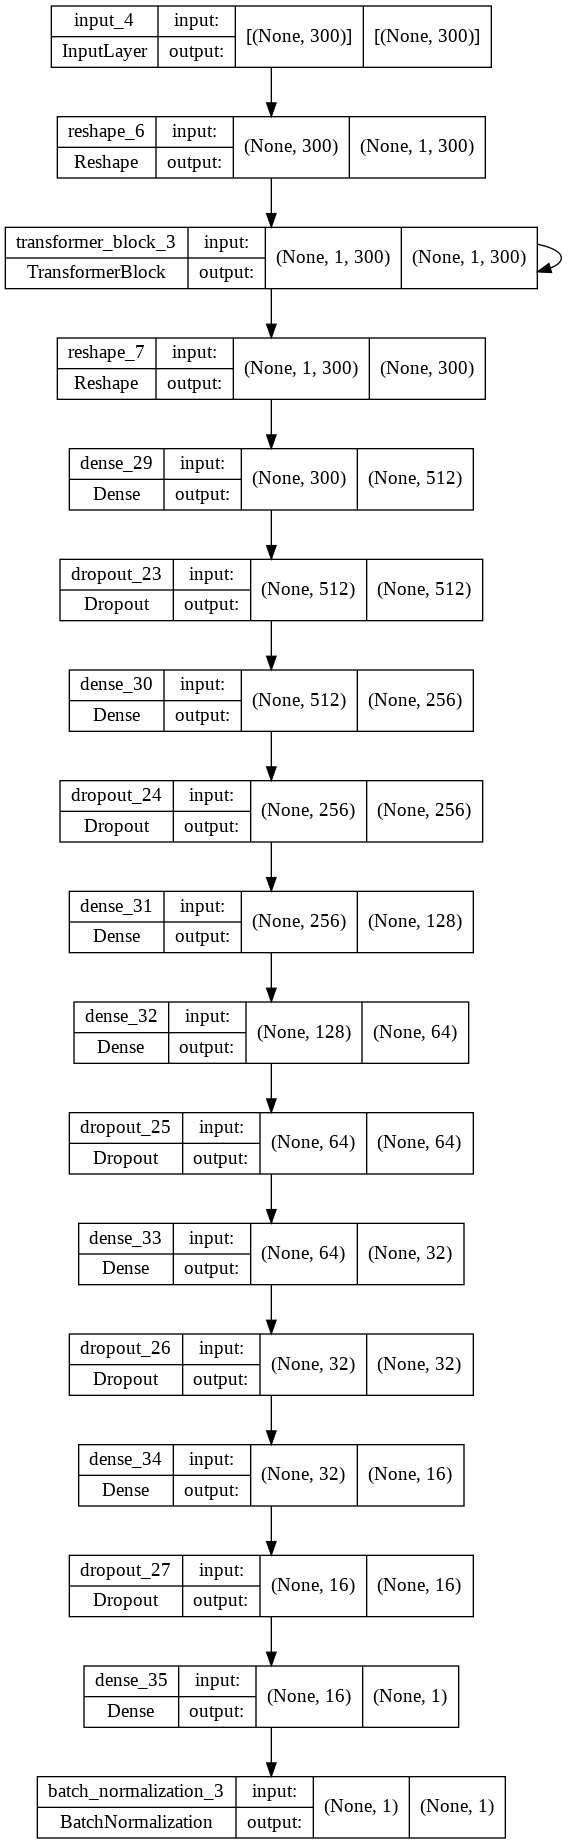

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model_pretrained = get_model_transformer()
model_pretrained.load_weights("/content/model_1.tf")

In [ ]:
def make_test_dataset2(feature, batch_size=1024):
    ds = tf.data.Dataset.from_tensor_slices(feature)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
test_ds = make_test_dataset2(val_data[features])

In [ ]:
y_pred = model_pretrained.predict(test_ds)

In [ ]:
y_pred.reshape(-1)

array([ 0.02273047, -0.011073  , -0.02909887, ...,  0.01755066,
        0.00625037, -0.11245453], dtype=float32)

In [ ]:
checkpoint = keras.callbacks.ModelCheckpoint(f"model_1.tf", monitor="val_loss", mode="min", save_best_only=True, save_weights_only=True)
early_stop = keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_ds, epochs=30, validation_data=val_ds, shuffle=False, callbacks=[checkpoint, early_stop])
model.save_weights(f"model_1.tf")

Epoch 1/30
2377/2377 [==============================] - 170s 68ms/step - loss: 103.3719 - mse: 1.7685 - mae: 0.9521 - mape: 342300.1250 - rmse: 1.3299 - val_loss: 96.8174 - val_mse: 0.8587 - val_mae: 0.6241 - val_mape: 95543.0391 - val_rmse: 0.9266
Epoch 2/30
2377/2377 [==============================] - 161s 68ms/step - loss: 92.3102 - mse: 1.6170 - mae: 0.8855 - mape: 271054.5938 - rmse: 1.2716 - val_loss: 86.4561 - val_mse: 0.8714 - val_mae: 0.6378 - val_mape: 98255.6328 - val_rmse: 0.9335
Epoch 3/30
2377/2377 [==============================] - 161s 68ms/step - loss: 82.2806 - mse: 1.4891 - mae: 0.8409 - mape: 227484.0469 - rmse: 1.2203 - val_loss: 77.0198 - val_mse: 0.8819 - val_mae: 0.6438 - val_mape: 106823.4062 - val_rmse: 0.9391
Epoch 4/30
2377/2377 [==============================] - 161s 68ms/step - loss: 73.1496 - mse: 1.3752 - mae: 0.8040 - mape: 203072.6094 - rmse: 1.1727 - val_loss: 68.4188 - val_mse: 0.8778 - val_mae: 0.6479 - val_mape: 89656.9531 - val_rmse: 0.9369
Epoch 

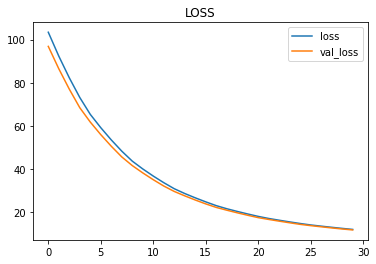

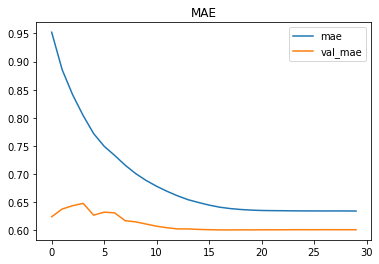

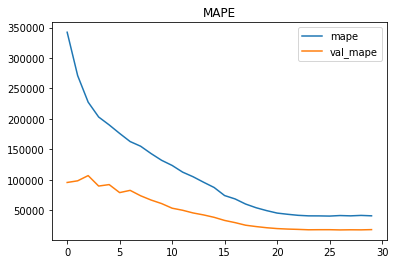

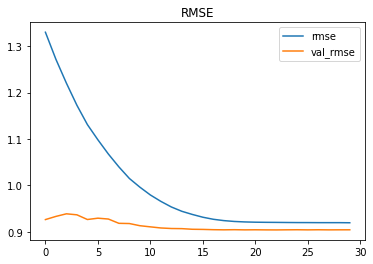

In [ ]:
for metric in ["loss", "mae", "mape", "rmse"]:
  pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
  plt.title(metric.upper())
  plt.show()

### Using random mask trick

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
def gen_ids_and_skf_idxs():
    train = pd.read_parquet("/content/drive/MyDrive/CSC413/Final Project/data/train_low_mem.parquet")
    investment_id = train[["investment_id"]].astype('int64')
    train.pop("investment_id")
    train.pop("time_id")
    train.pop("target")
    skf = StratifiedKFold(5, shuffle=True, random_state=42)
    idxs = list(enumerate(skf.split(train, investment_id)))
    del train
    gc.collect()
    return investment_id, idxs

In [ ]:
investment_id, idxs = gen_ids_and_skf_idxs()

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  UserWarning,


In [ ]:
def correlation(x, y, axis=-2):
    xmean = tf.reduce_mean(x, axis=axis)
    ymean = tf.reduce_mean(y, axis=axis)
    cossim = keras.losses.cosine_similarity(x - xmean, y - ymean, axis=axis)
    return 1 + cossim

In [ ]:
# Random mask:
# To force the inv_embedding layer to see the OOV id (0 in this case) in train data, which may  .
# And then when the model faces OOV investment_ids, the embedding of those ids would not be too random.

def random_mask(feas, target, ratio=0.1):
    inv_id, fea = feas
    mask = tf.random.uniform(tf.shape(inv_id)) < ratio
    inv_id = tf.where(mask, tf.constant(-1, dtype=tf.int64), inv_id)
    return (inv_id, fea), target

In [ ]:
def make_dataset(feature, investment_id, y, batch_size=512, mode="train"):
    ds = tf.data.Dataset.from_tensor_slices(((investment_id, feature), y))
    if mode == "train":
        ds = ds.map(random_mask).shuffle(batch_size * 4)
    ds = ds.batch(batch_size).cache().prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
def get_tf_dataset(train_idx, test_idx):
    n_features = 300
    features = [f'f_{i}' for i in range(n_features)]
    df = pd.read_parquet("/content/drive/MyDrive/CSC413/Final Project/data/train_low_mem.parquet")
    con_feas = df[features]
    y = df['target']
    train_dataset = make_dataset(con_feas.iloc[train_idx, :], investment_id.iloc[train_idx], y.iloc[train_idx])
    val_dataset = make_dataset(con_feas.iloc[test_idx, :], investment_id.iloc[test_idx], y.iloc[test_idx], mode="valid")
    
    del df, con_feas, y
    gc.collect()
    
    return train_dataset, val_dataset

Scheduler which can be used for lr decay, weight decay, temperature decay, etc..

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
investment_ids = list(np.unique(investment_id.values))
investment_id_size = len(investment_ids) + 1
id_lookup_layer = layers.IntegerLookup(max_tokens=investment_id_size)
id_lookup_layer.adapt(investment_id)

In [ ]:
def get_model_transformer():
  embed_dim = 300  # Embedding size for each token
  num_heads = 8  # Number of attention heads
  ff_dim = 512  # Hidden layer size in feed forward network inside transformer

  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  features_input = tf.keras.Input((300,), dtype=tf.float32)
  investment_id_input = tf.keras.Input((1,))

  investment_id_x = id_lookup_layer(investment_id_input)
  investment_id_x = layers.Embedding(investment_id_size, 32)(investment_id_x)
  investment_id_x = layers.Dense(64, activation='swish', kernel_initializer='he_normal', bias_initializer='zeros')(investment_id_x)
  investment_id_x = layers.Dropout(0.5)(investment_id_x)
  investment_id_x = layers.Dense(32, activation='swish', kernel_initializer='he_normal', bias_initializer='zeros')(investment_id_x)
  investment_id_x = layers.Dropout(0.5)(investment_id_x)
  investment_id_x = tf.squeeze(investment_id_x, axis=1)

  features_inputs = tf.expand_dims(investment_id_x, axis = -1) + tf.expand_dims(features_input, axis = 1)
  # (None, 32, 300)

# 6 transformer blocks
  features_x = transformer_block(features_inputs)

  features_x = layers.Reshape((-1,))(features_x)
# MLP for output
  output_x = layers.Dense(512, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1))(features_x)
  output_x = layers.Dropout(0.6)(output_x)
  output_x = layers.Dense(256, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1))(output_x)
  output_x = layers.Dropout(0.6)(output_x)
  output_x = layers.Dense(128, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1))(output_x)
  output_x = layers.Dense(64, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1),
                          kernel_regularizer="l2")(output_x)
  output_x = layers.Dropout(0.6)(output_x)
  output_x = layers.Dense(32, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1),
                          kernel_regularizer="l2")(output_x)
  output_x = layers.Dropout(0.6)(output_x)
  output_x = layers.Dense(16, activation='swish',
                          kernel_initializer=initializers.RandomNormal(stddev=1),
                          kernel_regularizer="l2")(output_x)
  output_x = layers.Dropout(0.6)(output_x)
  output = layers.Dense(1)(output_x)
  output = tf.keras.layers.BatchNormalization(axis=1)(output)

# Model compilation
  rmse = keras.metrics.RootMeanSquaredError(name="rmse")
  model = tf.keras.Model(inputs=[investment_id_input, features_input], outputs=[output])
  # learning rate decay in Adam
  initial_learning_rate = 5e-4
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True)
  model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                loss='mse', 
                metrics=[rmse, correlation])
  return model

In [ ]:
model = get_model_transformer()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 integer_lookup (IntegerLookup)  (None, 1)           0           ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 32)        114560      ['integer_lookup[0][0]']         
                                                                                                  
 dense_2 (Dense)                (None, 1, 64)        2112        ['embedding[0][0]']              
                                                                                              

the 0th fold:
train_idx and test_idx:
[      0       1       2 ... 3141406 3141407 3141409] [      4       5      10 ... 3141399 3141404 3141408]
get tf_dataset...
get model...
start training...
Epoch 1/30
4909/4909 [==============================] - 272s 55ms/step - loss: 28.5034 - rmse: 0.9989 - correlation: 0.9651 - val_loss: 2.3722 - val_rmse: 0.9197 - val_correlation: 0.9083
Epoch 2/30
4909/4909 [==============================] - 265s 54ms/step - loss: 1.1001 - rmse: 0.9157 - correlation: 0.9117 - val_loss: 0.8487 - val_rmse: 0.9192 - val_correlation: 0.9302
Epoch 3/30
4909/4909 [==============================] - 265s 54ms/step - loss: 0.8388 - rmse: 0.9148 - correlation: 0.9006 - val_loss: 0.8448 - val_rmse: 0.9180 - val_correlation: 0.9136
Epoch 4/30
4909/4909 [==============================] - 265s 54ms/step - loss: 0.8376 - rmse: 0.9142 - correlation: 0.8945 - val_loss: 0.8437 - val_rmse: 0.9173 - val_correlation: 0.9091
Epoch 5/30
4909/4909 [==============================] - 

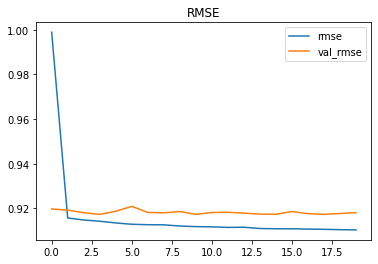

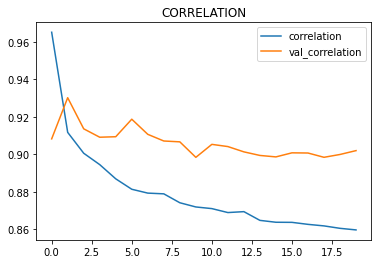

the 1th fold:
train_idx and test_idx:
[      0       1       4 ... 3141407 3141408 3141409] [      2       3      18 ... 3141392 3141396 3141406]
get tf_dataset...
get model...
start training...
Epoch 1/30
4909/4909 [==============================] - 271s 55ms/step - loss: 28.4879 - rmse: 1.0004 - correlation: 0.9734 - val_loss: 2.4187 - val_rmse: 0.9190 - val_correlation: 0.9170
Epoch 2/30
4909/4909 [==============================] - 265s 54ms/step - loss: 1.1254 - rmse: 0.9179 - correlation: 0.9380 - val_loss: 0.8451 - val_rmse: 0.9177 - val_correlation: 0.9169
Epoch 3/30
4909/4909 [==============================] - 265s 54ms/step - loss: 0.8427 - rmse: 0.9172 - correlation: 0.9259 - val_loss: 0.8415 - val_rmse: 0.9167 - val_correlation: 0.9138
Epoch 4/30
4909/4909 [==============================] - 266s 54ms/step - loss: 0.8417 - rmse: 0.9168 - correlation: 0.9204 - val_loss: 0.8421 - val_rmse: 0.9172 - val_correlation: 0.9100
Epoch 5/30
4909/4909 [==============================] - 

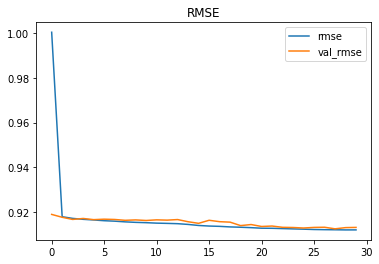

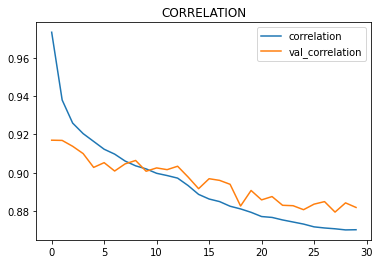

the 2th fold:
train_idx and test_idx:
[      2       3       4 ... 3141407 3141408 3141409] [      0       1       8 ... 3141388 3141395 3141398]
get tf_dataset...
get model...
start training...
Epoch 1/30
4909/4909 [==============================] - 272s 55ms/step - loss: 26.8878 - rmse: 0.9960 - correlation: 0.9472 - val_loss: 2.0879 - val_rmse: 0.9198 - val_correlation: 0.9160
Epoch 2/30
4909/4909 [==============================] - 267s 54ms/step - loss: 1.0373 - rmse: 0.9153 - correlation: 0.9088 - val_loss: 0.8524 - val_rmse: 0.9216 - val_correlation: 0.9220
Epoch 3/30
4909/4909 [==============================] - 267s 54ms/step - loss: 0.8384 - rmse: 0.9147 - correlation: 0.9015 - val_loss: 0.8478 - val_rmse: 0.9196 - val_correlation: 0.9163
Epoch 4/30
4909/4909 [==============================] - 267s 54ms/step - loss: 0.8371 - rmse: 0.9140 - correlation: 0.8936 - val_loss: 0.8459 - val_rmse: 0.9184 - val_correlation: 0.9122
Epoch 5/30
4909/4909 [==============================] - 

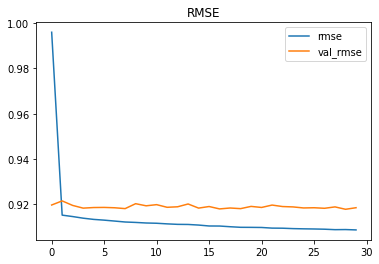

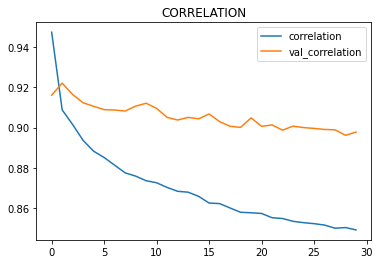

the 3th fold:
the 4th fold:
CPU times: user 5h 3min 27s, sys: 21min 33s, total: 5h 25min 1s
Wall time: 5h 55min 6s


In [ ]:
%%time
for idx, (train_idx, test_idx) in idxs:
    print(f"the {idx}th fold:")
    if (idx >= 3):
      continue
    print("train_idx and test_idx:")
    print(train_idx, test_idx)
    
    print("get tf_dataset...")
    train_dataset, val_dataset = get_tf_dataset(train_idx, test_idx)

    print("get model...")
    model = get_model_transformer()

    checkpoint = keras.callbacks.ModelCheckpoint(f'model_{idx}.tf', monitor="val_correlation", save_best_only=True, save_weights_only=True)
    early_stop = keras.callbacks.EarlyStopping(monitor="val_correlation", patience=10, mode='min')
    
    print("start training...")
    history = model.fit(train_dataset, epochs=30, validation_data=val_dataset, callbacks=[checkpoint, early_stop])
    
    model.save_weights(f"model_{idx}.tf")
    for metric in ["rmse", "correlation"]:
        pd.DataFrame(history.history, columns=[metric, f"val_{metric}"]).plot()
        plt.title(metric.upper())
        plt.show()
    
    del train_dataset, val_dataset, model, checkpoint, early_stop, history
    gc.collect()

In [ ]:
!cp -v ./*.tf.* /content/drive/MyDrive/CSC413

'./model_0.tf.data-00000-of-00001' -> '/content/drive/MyDrive/CSC413/model_0.tf.data-00000-of-00001'
'./model_0.tf.index' -> '/content/drive/MyDrive/CSC413/model_0.tf.index'
'./model_1.tf.data-00000-of-00001' -> '/content/drive/MyDrive/CSC413/model_1.tf.data-00000-of-00001'
'./model_1.tf.index' -> '/content/drive/MyDrive/CSC413/model_1.tf.index'
'./model_2.tf.data-00000-of-00001' -> '/content/drive/MyDrive/CSC413/model_2.tf.data-00000-of-00001'
'./model_2.tf.index' -> '/content/drive/MyDrive/CSC413/model_2.tf.index'
'./model_3.tf.data-00000-of-00001' -> '/content/drive/MyDrive/CSC413/model_3.tf.data-00000-of-00001'
'./model_3.tf.index' -> '/content/drive/MyDrive/CSC413/model_3.tf.index'
'./model_4.tf.data-00000-of-00001' -> '/content/drive/MyDrive/CSC413/model_4.tf.data-00000-of-00001'
'./model_4.tf.index' -> '/content/drive/MyDrive/CSC413/model_4.tf.index'
